<a href="https://colab.research.google.com/github/AtrCheema/Miscellaneous_DL_Tutorials/blob/master/dense_layer_model_tf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
import tensorflow as tf

import os
import random
from sklearn.metrics import mean_squared_error
from math import sqrt
from scipy.stats.stats import linregress
from collections import OrderedDict
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline


np.set_printoptions(suppress=True) # to suppress scientific notation while printing arrays

def reset_graph(seed=2):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

tf.test.is_gpu_available()


True

#### Some Utils

These are utitlity functions that we will need to during this exercise to calculate differnt stuff etc.

In [0]:

import random

class FindErrors(object):

    def __init__(self, actual, predicted, fil = None, epoch=None, meta_data='', chunk=None):
        actual = actual.reshape(-1,)
        predicted = predicted.reshape(-1,)

        self.chunk = chunk or []
        self.true = actual # observed/real value
        self.predicted = predicted
        self.fil = fil
        self.epoch = epoch
        self.meta_data = meta_data


    def rmse(self):
        return sqrt(mean_squared_error(self.true, self.predicted))

    def mse(self):
        return mean_squared_error(self.true, self.predicted)

    def r2(self):
        if self.true.ndim>1:
            self.true = self.true.reshape(-1,)
        if self.predicted.ndim>1:
            self.predicted = self.predicted.reshape(-1,)
        slope, intercept, r_value, p_value, std_err = linregress(self.true, self.predicted)
        return r_value ** 2

    def RSR(self):
        return self.rmse() / np.std(self.true)

    def NSE(self):
        nse = 1 - sum((self.predicted - self.true) ** 2) / sum((self.true - np.mean(self.true)) ** 2)
        return nse

    def APB(self):
        """ absolute percent bias"""
        APB = 100.0 * sum(abs(self.predicted - self.true)) / sum(self.true)  # Absolute percent bias
        return APB

    def percent_bias(self):
        PerBias = 100.0 * sum(self.predicted - self.true) / sum(self.true)  # percent bias
        return PerBias

    def nrmse(self):
        """ Normalized Root Mean Squared Error """
        return self.rmse() / (self.true.max() - self.true.min())

    def mae(self):
        """ Mean Absolute Error """
        return np.mean(np.abs(self.true - self.predicted))


class Utils(object):

    # codes for some colors
    colors = {'true': np.array([0.07233712, 0.470282, 0.24355425]),
            'pred': np.array([0.81831849, 0.17526342, 0.4766505]),
            'train_samples': np.array([0.9624212,  0.28477194, 0.4760216]),
            'test_samples': np.array([0.51618149, 0.16053867, 0.45268923]),
            'prediction': np.array([0.86537652, 0.18864455, 0.08620183]),
            'training': np.array([0.92359535, 0.41150655, 0.42089012])
        }


    @staticmethod
    def read_from_file(in_features=None, out_features=None, rows=None, print_lines=20):
        
        df = pd.read_csv('input.csv')

        cols = df.columns

        ins = list(np.random.choice(cols[1:-3], size=in_features))
        outs = list(np.random.choice(cols[-2:], size=out_features))

        req_cols = ins + outs
        df1 = df[req_cols]

        in_data = df1.values

        print(in_data[0:print_lines])  
        print('\n {} \n'.format(in_data.shape))
        print(in_data[-print_lines:])

        return in_data


    @staticmethod
    def generate_data(inputs, outputs, data_len, print_lines=20):
        in_data = np.random.random((data_len, inputs))
        y = np.full((data_len, outputs), np.nan)

        funcs = [np.sum, np.prod, np.trapz]

        for out in range(out_features):
            func = np.random.choice(funcs)
            print('doing ', func.__name__)
            y[:,out] = func(in_data, axis=1)
        
        in_data = np.hstack((in_data, y))

        print(in_data[0:print_lines])  
        print('\n {} \n'.format(in_data.shape))
        print(in_data[-print_lines:])

        return in_data

    @staticmethod
    def print_errors(true, pred):

        er = FindErrors(true, pred)
        for err in ['r2', 'NSE', 'APB', 'percent_bias', 'RSR', 'rmse', 'mse','nrmse', 'mae']:
            print('{:20}  {:<10.5f} '.format(err, getattr(er, err)()))

    @staticmethod
    def plot_scatter(true, pred, _name=None):
        fig, ax = plt.subplots(1)
        Utils.set_fig_dim(fig, 8,6)

        ax.scatter(true, pred)
        #plt.savefig(_name, dpi=300, bbox_inches='tight')
        plt.show()
        plt.close(fig)


    @staticmethod
    def random_array(_length, lower=0.0, upper=0.5):
        """This creates a random array of length `length` and the floats vary between `lower` and `upper`."""
        rand_array = np.zeros((_length))
        for i in range(_length):
            rand_array[i] = random.uniform(lower, upper)
        return rand_array


    @staticmethod
    def plot_loss(train_loss_array, test_loss_array=None, _name=' ', log=False, _path=None):

        if test_loss_array:
            ht = 10
            _fig, (ax1, ax2) = plt.subplots(2, sharex='all')
        else:
            _fig, ax1 = plt.subplots(1, sharex='all')
            ht = 5

        _fig.set_figheight(ht)
        Utils.process_axis(ax1, train_loss_array, style='-', label='training ' + _name, leg_fs=12,
                           y_label=_name, yl_fs=14,ms=2, log=log, x_label="Epochs")

        if test_loss_array:
            Utils.process_axis(ax2, test_loss_array, label='Validation ' + _name, leg_fs=12,
                           y_label=_name, yl_fs=14, x_label='Epochs', ms=2, log=log)

        _fig.suptitle('Loss variation with training epochs', fontsize=18)

        #plt.savefig(_path + "/loss_" + _name, dpi=300, bbox_inches='tight')
        plt.show()


    @staticmethod
    def process_axis(axis,
                    data,
                    style= '.',
                    x_label = "Time",
                    xl_fs = 14,     # x label font size
                    y_label=" ",
                    yl_fs = 14,                        # ylabel font size
                    leg_pos="center left",
                    label = " ",   # legend
                    ms = 5,        # markersize
                    leg_fs=16,
                    leg_ms = 4,     # legend scale
                    xtp_ls = 12, # x tick_params labelsize
                    ytp_ls = 12, # x tick_params labelsize
                    log= False,
                    show_xaxis=True,
                    top_spine = True,
                    bottom_spine=True,
                    invert_yaxis=False):

        if label in Utils.colors:
            c = colors[label]
        else:
            c = Utils.random_array(3, 0.01, 0.99)
            print('for ', label, c)
        
        axis.plot(data, style, markersize=ms, color=c, label=label)
            
        axis.legend(loc=leg_pos, fontsize=leg_fs, markerscale=leg_ms)
        axis.set_ylabel(y_label, fontsize=yl_fs, color=c)

        if log:
            axis.set_yscale('log')

        if invert_yaxis:
            axis.set_ylim(axis.get_ylim()[::-1])

        axis.tick_params(axis="x", which='major', labelsize=xtp_ls, colors=c)
        axis.tick_params(axis="y", which='major', labelsize=ytp_ls, colors='k')
        axis.get_xaxis().set_visible(show_xaxis)

        if show_xaxis:
            axis.set_xlabel(x_label, fontsize=xl_fs, color='k')

        axis.spines['top'].set_visible(top_spine)
        axis.spines['bottom'].set_visible(bottom_spine)


    @staticmethod
    def set_fig_dim(fig, width, height):
        fig.set_figwidth(width)
        fig.set_figheight(height)
        return


utils = Utils()

## Model

Following class facilitates to build neural model

In [0]:

from sklearn.preprocessing import MinMaxScaler

class Model(object):

    def __init__(self, nn_conf, data):
        self.scalers = None
        self.nn_conf = nn_conf
        self.data_n = self.normalization(data)    

    def normalization(self, data):
        if self.nn_conf['normalization']:  # normalizing data
            # container for normalized input data
            dataset_n = np.full(data.shape, np.nan)
            self.scalers = OrderedDict()

            for dat in range(data.shape[1]):
                value = data[:,dat]
                val_scaler = MinMaxScaler(feature_range=(0, 1))
                val_norm = val_scaler.fit_transform(value.reshape(-1,1))
                dataset_n[:,dat] = val_norm.reshape(-1,)
                self.scalers[str(dat) + '_scaler'] = val_scaler

            return dataset_n
        else:
            return data


    def batch_generator(self, data, args, verbose=True):
        ins = args['in_features']
        outs = args['out_features']
        min_idx = args['min_ind']
        max_idx = args['max_ind']
        bat_size = args['batch_size']

        X = data[min_idx:max_idx, 0:ins]
        Y = data[min_idx:max_idx, -outs:]

        residue = X.shape[0] % bat_size

        no_of_batches = int(X.shape[0] // bat_size)
        if verbose:
            print('no of batches: ', no_of_batches)

        if min_idx == 0:
            self.train_batches = no_of_batches
        else:
            self.test_batches = no_of_batches

        gen_i = 1
        while 1:
            gen_i +=1

            st = 0
            en = bat_size
            for bat in range(no_of_batches):

                x = X[st:en,:]
                y = Y[st:en,:]

                st += bat_size
                en += bat_size

                yield x,y 
    
    def build_nn(self):
        
        in_feat = self.nn_conf['in_features']
        lr = self.nn_conf['lr']
        loss = self.nn_conf['loss']
        lyrs_conf = self.nn_conf['layers_conf']


        reset_graph()
        k_model = Sequential()

        layer = 0
        for l,lp in lyrs_conf.items():
            
            if layer == 0:
                k_model.add(lp['lyr']( units = lp['units'], activation=lp['acts'], input_shape=(in_feat,)))
                self.add_misc_lyrs(k_model, lp['dropout'], lp['BatchNorm'])

            else:
                k_model.add(lp['lyr']( units = lp['units'], activation=lp['acts']))
                self.add_misc_lyrs(k_model, lp['dropout'], lp['BatchNorm'])

            layer += 1

        optimizer=tf.keras.optimizers.Adam(
            learning_rate=lr, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False,
            name='Adam'
        )


        k_model.compile(loss=nn_conf['loss'],
                    optimizer=optimizer)
        
        self.k_model = k_model

        return k_model
    
    @staticmethod
    def add_misc_lyrs(k_model, dropout=None, BatchNorm=False):
        if dropout:
            k_model.add(Dropout(dropout))
        if BatchNorm:
            k_model.add(BatchNormalization())
        return

    
    def train_nn(self, train_args):
    
        train_gen = self.batch_generator(self.data_n, train_args)
        next(train_gen)
        train_gen = self.batch_generator(self.data_n, train_args, verbose=False)

        epochs = self.nn_conf['training_epochs']

        history = self.k_model.fit_generator(train_gen,
                                    steps_per_epoch=self.train_batches,
                                    epochs=epochs)
        return history


    def test_nn(self, args, mode='test'):

        out_feat = self.nn_conf['out_features']

        gen = self.batch_generator(self.data_n, args)
        next(gen)
        gen = self.batch_generator(self.data_n, args, verbose=False)

        # get number of batches
        batches = self.test_batches if mode=='test' else self.train_batches

        true = np.full((int(batches*nn_conf['batch_size']), out_feat), np.nan)

        st = 0
        en = nn_conf['batch_size']
        for i in range(batches):
            _, true[st:en,:] = next(gen) 
            st += nn_conf['batch_size']
            en += nn_conf['batch_size']

        gen = self.batch_generator(self.data_n, args, verbose=False)
        predictions = self.k_model.predict_generator(gen,
                                                   steps=batches)  
        
        if self.nn_conf['normalization']:
            true, predictions = self.denormalize_y(true, predictions)
        
         
        return true, predictions
    

    def denormalize_y(self, true, pred):
        out_feat = self.nn_conf['out_features']

        st_idx = len(self.scalers) - out_features
        for i in range(out_features):

            idx = st_idx + i
            scaler_name = str(list(self.scalers.keys())[idx])
            print(scaler_name, 'scaler name')
            
            y_scaler = self.scalers[scaler_name]  
            true[:,i] = y_scaler.inverse_transform(true[:,i].reshape(-1, 1)).reshape(-1,)
            pred[:,i] = y_scaler.inverse_transform(pred[:,i].reshape(-1, 1)).reshape(-1,)
        
        return true, pred




## Getting Data

In [60]:
rows = 1000
in_features = 4
out_features = 2

# if 'input.csv' in os.listdir(os.getcwd()):
#     data = utils.read_from_file(in_features, out_features, rows, print_lines=3)
# else:
#     data = utils.generate_data(in_features, out_features, rows)

data = utils.generate_data(in_features, out_features, rows, 15)


doing  sum
doing  trapz
[[0.31514699 0.13144811 0.686338   0.99622171 2.12915481 1.47347047]
 [0.96072615 0.00450977 0.36787285 0.37653266 1.70964142 1.04101202]
 [0.23118034 0.66269174 0.14468565 0.46149771 1.50005544 1.15371641]
 [0.32270638 0.21974394 0.08375882 0.38698797 1.01319711 0.65834993]
 [0.54536434 0.18311795 0.74081957 0.07389808 1.54319994 1.23356873]
 [0.41910408 0.56062468 0.86448095 0.7866353  2.63084501 2.02797532]
 [0.39901108 0.77564464 0.70568237 0.09989261 1.9802307  1.73077886]
 [0.83241207 0.08202438 0.57733526 0.43173162 1.92350334 1.29143149]
 [0.85133903 0.11310193 0.08738812 0.81374354 1.86557262 1.03303133]
 [0.48060877 0.66608967 0.78965305 0.46544195 2.40179343 1.92876807]
 [0.62491512 0.79035601 0.84854539 0.73738716 3.00120368 2.32005254]
 [0.34879346 0.73084908 0.86595277 0.49994567 2.44554098 2.02117141]
 [0.60056364 0.32100179 0.37313865 0.75179215 2.04649623 1.37031833]
 [0.68289551 0.48503134 0.40448759 0.70353867 2.27595311 1.58273602]
 [0.213520

### Building Model



In [0]:
"""
*****************************************************************************
             Change values in this cell and see model performacne
*****************************************************************************
"""

nn_conf = {
    'batch_size': 4,
    'lr': 0.00001,  # learning rate
    'loss': 'mse', # mae,  
    'training_epochs': 50,
    'normalization': True  # False/ True
}

lyrs = OrderedDict()
# you can add or remove layers with the exception that last layer must have units = out_features
# acts: activations, can be None or 'relu', 'tanh', 'sigmoid', 'elu'
# dropout can be any fractional value or None
#BatchNorm can be True or False

lyrs[0] = {'lyr': Dense, 'units': 64, 'acts': None, 'dropout': 0.2, 'BatchNorm': False}
lyrs[1] = {'lyr': Dense, 'units': 32, 'acts': None, 'dropout': 0.2, 'BatchNorm': False}
#lyrs[2] ={'lyr': Dense, 'units': 16, 'acts': None, 'dropout': 0.2, 'BatchNorm': False}
lyrs[3] = {'lyr': Dense, 'units': out_features, 'acts': None, 'dropout': None, 'BatchNorm': False}


# percentage of data to be considered as training data
# remaining data will be considered as test data
training_percent = 0.7  


In [89]:
st_ind = 0  # must be 0
end_ind = int(data.shape[0] * training_percent)

train_args = {
    'batch_size': nn_conf['batch_size'],
    'min_ind': st_ind,
    'max_ind': end_ind,
    'in_features': in_features,
    'out_features': out_features
}

test_args = train_args.copy()
test_args['min_ind'] = end_ind
test_args['max_ind'] = data.shape[0]


nn_conf['layers_conf'] = lyrs
nn_conf['in_features'] = in_features
nn_conf['out_features'] = out_features



model = Model(nn_conf, data=data)

keras_model = model.build_nn()

keras_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                320       
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 2,466
Trainable params: 2,466
Non-trainable params: 0
_________________________________________________________________


In [0]:
# train_gen = model.batch_generator(data, train_args)
# test_gen = model.batch_generator(data, test_args)

In [0]:
# x,y = next(train_gen)
# print(x.shape, y.shape)
# print(x,'\n', y)

In [0]:
# x,y = next(test_gen)
# print(x.shape, y.shape)
# print(x,'\n', y)
# model.scalers

### Train the model

In [93]:
history = model.train_nn( train_args)

no of batches:  10
Epoch 1/50
10/10 [==============================] - 0s 33ms/step - loss: 0.2046
Epoch 2/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0655
Epoch 3/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0550
Epoch 4/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0426
Epoch 5/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0389
Epoch 6/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0338
Epoch 7/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0295
Epoch 8/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0259
Epoch 9/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0244
Epoch 10/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0250
Epoch 11/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0236
Epoch 12/50
10/10 [==============================] - 0s 3ms/step - loss: 0.0210
Epoch 13/50
10/10 [==========

for  training   [0.71267536 0.87658585 0.42038226]


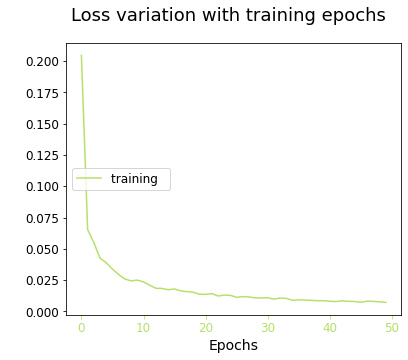

In [94]:
utils.plot_loss(history.history['loss'])

### Make predictions

We evaluate our model on test data

In [68]:
test_true, test_predictions = model.test_nn(test_args)

no of batches:  75
4_scaler scaler name
5_scaler scaler name


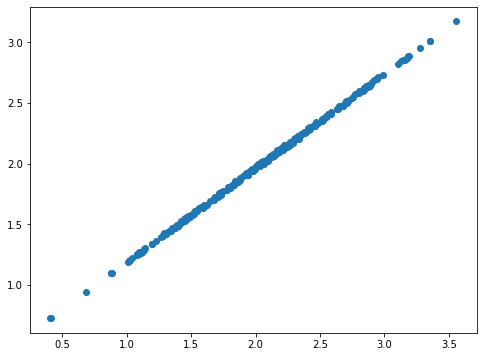

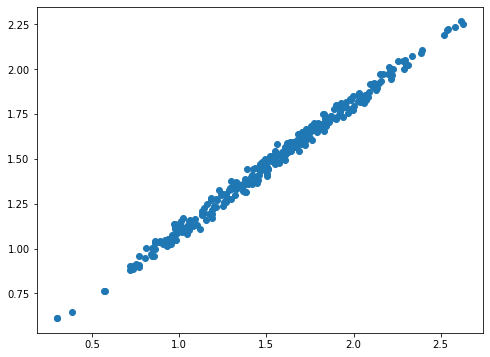

In [69]:
for i in range(out_features):
    utils.plot_scatter(test_true[:,i], test_predictions[:,i])

In [70]:
for i in range(out_features):
    utils.print_errors(test_true[:,i], test_predictions[:,i])
    print('\n\n')


r2                    0.99970    
NSE                   0.94443    
APB                   5.44698    
percent_bias          -2.08895   
RSR                   0.23574    
rmse                  0.13539    
mse                   0.01833    
nrmse                 0.04299    
mae                   0.10982    



r2                    0.99274    
NSE                   0.91189    
APB                   7.17277    
percent_bias          -2.70865   
RSR                   0.29684    
rmse                  0.13368    
mse                   0.01787    
nrmse                 0.05741    
mae                   0.10797    





### Evaluate on Training data

In [71]:
train_true, train_predictions = model.test_nn(train_args, 'training')

no of batches:  175
4_scaler scaler name
5_scaler scaler name


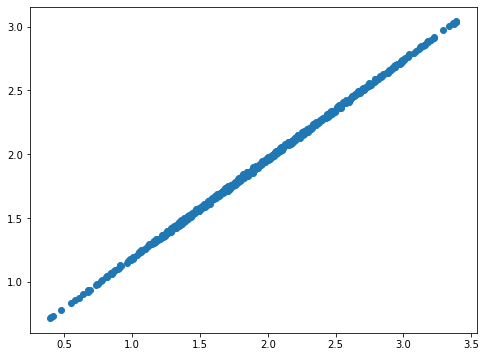

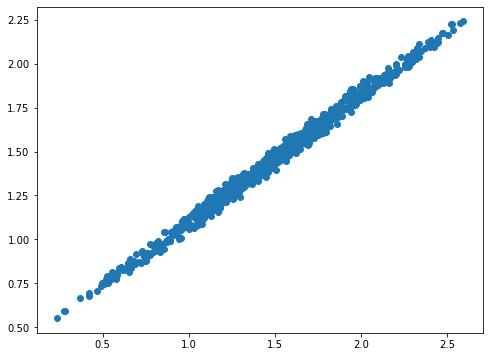

In [72]:
for i in range(out_features):
    utils.plot_scatter(train_true[:,i], train_predictions[:,i])

In [73]:
for i in range(out_features):
    utils.print_errors(train_true[:,i], train_predictions[:,i])
    print('\n\n')

r2                    0.99973    
NSE                   0.94724    
APB                   5.51671    
percent_bias          -1.52179   
RSR                   0.22969    
rmse                  0.13576    
mse                   0.01843    
nrmse                 0.04536    
mae                   0.10843    



r2                    0.99273    
NSE                   0.91451    
APB                   7.29015    
percent_bias          -2.16389   
RSR                   0.29238    
rmse                  0.13457    
mse                   0.01811    
nrmse                 0.05709    
mae                   0.10777    



